# Predicting price of airbnb houses and apartments, based on descriptions.

Tnis project is based on [Kaggle's dataset](https://www.kaggle.com/PromptCloudHQ/airbnb-property-data-from-texas) including Airbnb Property Data from Texas. Dataset contains more than 18,000 property listings from Texas, United States. So, the scope of this project is to build a model that predicts the rental price of a property per night. Dataset contains both textual and numeric data, so the model been fed with such features. I'll explain whatever it needs on the next lines.

#### Examine the content of the dataset

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('Airbnb_Texas_Rentals.csv')
df.head(3)

,Unnamed: 0,average_rate_per_night,bedrooms_count,city,date_of_listing,description,latitude,longitude,title,url
0,1,$27,2,Humble,May 2016,Welcome to stay in private room with queen bed...,30.020138,-95.293996,2 Private rooms/bathroom 10min from IAH airport,https://www.airbnb.com/rooms/18520444?location...
1,2,$149,4,San Antonio,November 2010,"Stylish, fully remodeled home in upscale NW – ...",29.503068,-98.447688,Unique Location! Alamo Heights - Designer Insp...,https://www.airbnb.com/rooms/17481455?location...
2,3,$59,1,Houston,January 2017,'River house on island close to the city' \nA ...,29.829352,-95.081549,River house near the city,https://www.airbnb.com/rooms/16926307?location...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18259 entries, 0 to 18258
Data columns (total 10 columns):
Unnamed: 0                18259 non-null int64
average_rate_per_night    18231 non-null object
bedrooms_count            18256 non-null object
city                      18259 non-null object
date_of_listing           18259 non-null object
description               18257 non-null object
latitude                  18225 non-null float64
longitude                 18225 non-null float64
title                     18256 non-null object
url                       18259 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 1.4+ MB


A few changes need to be done on the data...

In [3]:
# drop some columns
df = df.drop(['Unnamed: 0','url'], axis=1) 

In [4]:
# Missing values?
df.isna().sum()

average_rate_per_night    28
bedrooms_count             3
city                       0
date_of_listing            0
description                2
latitude                  34
longitude                 34
title                      3
dtype: int64

34 data points out of 18K it's not a big deal so I drop 'em

In [5]:
# drop all NA's
df = df.dropna().reset_index(drop=True)

In [6]:
# rename some columns
df = df.rename(columns={'average_rate_per_night': 'avg_cost',
                        'bedrooms_count': 'bedrooms',
                        'date_of_listing' : 'date'})

In [7]:
# split '$' dollar sign from rate_per_night and convert to an integer
df['avg_cost'] = df.avg_cost.apply(lambda x: x.split('$')[1]).astype(int)

# log scale price values
df['avg_cost_log'] = np.log1p(df['avg_cost']).astype('float32')

In [8]:
# convert 'bedrooms_count' from object to numeric.

df = df.replace({'bedrooms' : {'Studio' : 0}})   # Studio has 0 separate bedrooms.
df.bedrooms = df.bedrooms.astype(int)

In [9]:
# new data
df.head(2)

,avg_cost,bedrooms,city,date,description,latitude,longitude,title,avg_cost_log
0,27,2,Humble,May 2016,Welcome to stay in private room with queen bed...,30.020138,-95.293996,2 Private rooms/bathroom 10min from IAH airport,3.332205
1,149,4,San Antonio,November 2010,"Stylish, fully remodeled home in upscale NW – ...",29.503068,-98.447688,Unique Location! Alamo Heights - Designer Insp...,5.010635


### Feature Engineering 
#### Text pre-processing and generate new features

As always I'm doing a search over text data using regular expressions, and turn curiosity into feature engineering. Specifically, the next 'hyper-function' implements text cleaning, and removes:
- **html tags**, such as 'amp;'.
- **line feed**, like \n, \\n, \n\n.
- **airbnb urls**, all urls like "airbnb.com/rooms/".
- **punctuation**, excluding dots that are in numbers (eg. 2.5)
- **white spaces** that are redundant.

rename:
- **rename** electrical devices, such as w/d and a/c.
- **rename characters** that refer to bedrooms and bathrooms, like 'br', 'bed(s)', 'bdr', 'ba', 'bath'
- **convert** all square feet 

Tokenizer:
- **spaCy Tokenizer API** for lemmatization.

In [10]:
# FUNCTIONS for text cleaning

import spacy
import en_core_web_sm as en
nlp = en.load()
from spacy.tokenizer import Tokenizer

tokenizer = Tokenizer(nlp.vocab)

from bs4 import BeautifulSoup

# HTML
def remove_htmlTags(text):
    untagged = BeautifulSoup(text, 'lxml')
    return(untagged.get_text())


def chars(text):
    text = re.sub(r"((?:\\\\?n+))", ' ', text)
    return(re.sub(r"(?:\s+)", ' ', text))

# change 'br', 'bed(s)', 'bedrooms', 'bdr' to 'bedroom'
def bedroom(text):
    text = re.sub("/",' ', text)
    pattern = r"((?:([0-9]+)\s?br)|(?:([0-9]+)\s?bed(?!s)(rooms?)?)|(?:([0-9]+)\s?bdr?))"
    if re.findall(pattern, text):
        for m in re.compile(pattern).finditer(text):
            group = [grp for grp in list(m.groups()) if grp is not None]
            return(re.sub(group[0], group[1]+' bedroom', text))
    else:
        return(text)

# change 'ba', 'bath', 'bathrooms' to 'bathroom'
def bathroom(text):
    text = re.sub("/",' ', text)
    pattern = r"((?:([0-9]+)\s?(?:ba(th)?(rooms?)?)))"
    if re.findall(pattern, text):
        for m in re.compile(pattern).finditer(text):
            group = [grp for grp in list(m.groups()) if grp is not None]
            return(re.sub(group[0], group[1]+' bathroom', text))
    else:
        return(text)
    
# sf, sqft etc to Square Feet
def sqft(text):
    pattern = r"((?:\s?sqft)|(?:\s?sf)|(?:\s?(?:sq\.?\s?ft\.?)))"
    if re.findall(pattern, text.lower()):
        for m in re.compile(pattern).finditer(text):
            return(re.sub(m.group(), ' square feet ', text))
    else:
        return(text)
        
# Lemmatize words
def lemmas(text):
    text = [t.lemma_.lower().strip() if t.lemma_ != '-PRON-' else t.lower_ for t in text]
    return(text)


In [11]:
# Combining all functions to one

def text_cleaner(text, low = True, html = True, charLines = True, urls = True,
                 machines = True, bed = True, bath = True, sf = True,
                 punctuation = True, white_space = True, lemmatization = True):
    
    # lowercase
    if low:
        text = text.lower()
        text = re.sub('w/', 'with ', text)
        
    if html:
        text = remove_htmlTags(text)
        
    if charLines:
        text = chars(text)
    
    # remove airbnb.com urls
    if urls:
        text = re.sub(r"(?:https://(www.)?airbnb.com/rooms/[0-9]+)", ' ', text)
    
    # W/D, A/C devices
    if machines:
        text = re.sub('w/d', 'wash dryer', text)
        text = re.sub('a/c', 'air condition', text)

    if bed:
        text = bedroom(text)

    if bath:
        text = bathroom(text)
        text = re.sub('bth', ' bathroom', text)
        
    if sf:
        text = sqft(text)
    
    # punctuation, white spaces and dot removal
    if punctuation and white_space:
        text = re.sub(r"[^a-zA-Z0-9\.]", ' ', text)
        text = re.sub(' +', ' ', text)
        text = re.sub(r"(?<!\d)\.(?!\d)", '', text)
    
    # spaCy Tokenizer API
    text = tokenizer(text)
    
    if lemmatization:
        text = lemmas(text)
        text = [t for t in text if len(t)>1 or t.isdigit()]

    return(text)

In [12]:
# Apply functions on 'Title' and 'Description'

df['title'] = list(map(text_cleaner, df['title']))

df['description'] = list(map(text_cleaner, df['description']))

In [13]:
print(df.title[:2]); print('\n', df.description[:2])

0    [2, private, room, bathroom, 10min, from, iah,...
1    [unique, location, alamo, height, designer, in...
Name: title, dtype: object

 0    [welcome, to, stay, in, private, room, with, q...
1    [stylish, fully, remodel, home, in, upscale, n...
Name: description, dtype: object


In [14]:
# Check for empty data points after cleaning text documnets.

print('empty rows in description: ', len([empty for empty in df.description if empty == []]))
print('empty rows in title: ', len([empty for empty in df.title if empty == []]))

# fill empty rows.
for desc in df.description:
    if desc == []:
        # replace with a bigram
        desc.append('no_description')

for desc in df.title:
    if desc == []:
        # replace with a bigram
        desc.append('no_title')

empty rows in description:  56
empty rows in title:  11


#### A couple of new features: Sentence length and Distance from metro area.

In [15]:
# Length of Tokens

df['tok_len'] = list(map(len, df['description']))
df['tok_len'] = np.log1p(df['tok_len']).astype('float32')

In [16]:
# This feature extracts the distance between property and metro area of big TX cities. 
# As closer as to the city center is a property, the price might be larger.
# On the other hand if a property has 10 bedrooms, is possible to be at the suburbs or even more far.

# DISTANCE
from math import cos, sin, asin, sqrt, radians

rad_coors = [] # coordiantres in rads

# big cities of Texas, that are in the dataset
for cor in [[32.436161, -99.77401],
            [35.132131, -101.908448],
            [30.309522, -97.73171],
            [30.084549, -94.173759],
            [27.619349, -97.222016],
            [32.786636, -96.874669],
            [32.747097, -97.286434],
            [29.294488, -94.783691],
            [29.829352, -95.081549],
            [29.503068, -98.447688]]:
    rad_coors.append([radians(l) for l in cor]) #angles need to be in radians

# compute distance using ‘haversine’ formula.
def distance(lat, lon):
    R = 6371 #earth’s mean radius
    lat, lon = map(radians, (lat, lon))
    dists = []
    for cor in rad_coors:
        a = sin((cor[0]-lat) * 0.5)**2 + cos(cor[0])*cos(lat)*sin((cor[1]-lon)*0.5)**2
        dists.append(2 * R * asin(sqrt(a)))
        d = np.min(dists)
    return(d)

# map on new column
df['distance'] = list(map(distance, df['latitude'], df['longitude']))
# convert to log
df['Log_dist'] = np.log1p(df['distance']).astype('float32')


### Vocabulary and Word Vectors

#### We need to construct the vocabulary,

that comes out from entire corpus, title and description. Afterwards, I am using **pre-trained word embeddings**, generated with Stanford's **Glove** model. I'm chosing Twitter vectors generated from 2B tweets, 27B tokens, 1.2M words in vocabulary. We'll see if embeddings can help the model to generalize on test data.

In [17]:
from collections import Counter

tokens_count = Counter()

cols = ['title', 'description']
for col in cols:
    for word in df[col]:
        tokens_count.update(word)

print('unique total tokens = {}'.format(len(tokens_count)))

min_count = 10 # threshold for words with count less than 10
tokens = {token for token,count in tokens_count.items() if count >= min_count}

PAD, UNK = 'UNK', 'PAD' 
tokens = [UNK,PAD] + sorted(tokens)
print('vocabulary size: {}'.format(len(tokens)))

tokens_id = {idx: tok for tok, idx in enumerate(tokens)}

unique total tokens = 13346
vocabulary size: 3786


Download pre-trained word vectors from [here](https://nlp.stanford.edu/projects/glove/)

In [18]:
# Pre-trained GloVe 100d word vectors.

embeddings_index = {}

# get vectors
f = open('glove100d/glove-twitter-100.txt', 'r+', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

# dimensions of word vector space
EMBED_SIZE = 100

embedding_matrix = np.zeros((len(tokens_id), EMBED_SIZE))
for word,i in tokens_id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('size of matrix: {}'.format(len(embedding_matrix)))

Found 1193515 word vectors.
size of matrix: 3786


We got 3786 words out of 18K text documents. It would be better to have 1.8M and generate our own embeddings using Gensim. However, we can extract some bigrams to boost our model.

In [19]:
# Create some -Bigrams- with trimming.

from gensim.models.phrases import Phraser, Phrases

# Generate Bigrams and reject those with count less than 50 and score under 100.
bigrams = Phraser(Phrases(df.description, min_count=50, threshold=100))

description = [bigrams[text] for text in list(df.description)]

title = [bigrams[text] for text in list(df.title)]

We want to vectorize 'city' column from dataset. There are more than 500 cities and towns in this column, but we will only take into account the top 100 of them. Any other city-town out of this listing will be replaced with "Other".

In [20]:
# Vectorize cities of Texas. Keep Top 100 of them.

# extract top 100 cities and towns
cities = set([Counter(df.city).most_common(100)[i][0] for i in range(99)]) 

df['city'] = df['city'].apply(lambda city: city if city in cities else 'Other')


text_feats = ['title', 'description']
categorical_feats = ['city']
contin_feats = ['Log_dist', 'tok_len']

from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)

categorical_vectorizer.fit(df[categorical_feats].apply(dict, axis = 1))

# example of first 10 encodings. 
from itertools import islice
list(islice(categorical_vectorizer.vocabulary_.items(), 5))

[('city=Abilene', 0),
 ('city=Allen', 1),
 ('city=Alpine', 2),
 ('city=Amarillo', 3),
 ('city=Arlington', 4)]

In [21]:
np.expm1(df.tok_len).describe()

count    18217.000000
mean        53.565845
std         41.473835
min          1.000000
25%         35.999996
50%         47.000000
75%         72.000015
max        913.999878
Name: tok_len, dtype: float64

In [22]:
df.loc[np.expm1(df.tok_len)<25]['tok_len'].count()

2399

### The Model


Time to build the model using Keras functional API. Sequential Model does not really suits here, because we got multiple inputs which we concatenate before output layer.


First we need to change words into their index ID from vocabulary and then pad and truncate sequential data. We keep 50 words from description and 6 from title.

In [23]:
import keras
from keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, SpatialDropout1D, Dropout)
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

# Maximum length of sequeces.

D_MAXLEN = 50 # description
T_MAXLEN = 6  # title

# PAD description
desc_seq = [[tokens_id.get(t,0) for t in desc] for desc in description]
desc_seq = pad_sequences(desc_seq, D_MAXLEN, padding='post', truncating='post')

# PAD title
title_seq = [[tokens_id.get(t,0) for t in ttl] for ttl in title]
title_seq = pad_sequences(title_seq, T_MAXLEN, padding='post', truncating='post')


Using TensorFlow backend.


In [24]:
#df['description'] = [pad_title for pad_title in desc_seq]

#df['title'] = [pad_title for pad_title in title_seq]

In [25]:
import keras.backend as K
K.clear_session()


def multi_model(n_tokens = len(tokens), EMBED_SIZE = 100,
                embed_matrix = embedding_matrix,
                n_categ_feats = len(categorical_vectorizer.vocabulary_),
                hidden_size = 128, Sp_dr = None):
    
    # Embedding layer for textual data
    embed_layer = Embedding(n_tokens,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            trainable = False)
    
    title = Input(shape = [None], name = 'title')
    title_embed = embed_layer(title)
    #title_embed = SpatialDropout1D(Sp_dr)(title_embed)
    title_conv = Conv1D(filters = hidden_size, kernel_size = 2, activation = 'relu')(title_embed)
    title_out = GlobalMaxPooling1D()(title_conv)
    
    descr = Input(shape = [None], name = 'description')
    descr_embed = embed_layer(descr)
    #descr_embed = SpatialDropout1D(Sp_dr)(descr_embed)
    descr_conv = Conv1D(filters = hidden_size, kernel_size = 3, activation = 'relu')(descr_embed)
    descr_out = GlobalMaxPooling1D()(descr_conv)
    
    # Fully connected layers
    city = Input(shape=[n_categ_feats])
    city_out = Dense(hidden_size)(city)
    
    bedroom = Input(shape = (1,))
    bedroom_out = Dense(hidden_size)(bedroom)
    
    #distance = Input(shape = (1,))
    #distance_out = Dense(hidden_size)(distance)

    t_length = Input(shape = (1,))
    t_length_out = Dense(hidden_size)(t_length)
    
    
    concat = Concatenate()([title_out, descr_out, city_out, bedroom_out, t_length_out]) #, distance_out])#, t_length_out])
    
    output = Dropout(0.1)(concat)
    
    output = Dense(128, activation='relu')(output)
    
    output = Dropout(0.1)(output)
    
    output_layer = Dense(1)(output)
    
    model = keras.models.Model(inputs=[title, descr, city, bedroom, t_length], # distance], #, t_length],
                               outputs=[output_layer])
    
    model.compile(loss = ['mean_squared_error'],
                  optimizer = Adam(lr=0.001),
                  metrics = ['mean_absolute_error'])

    return(model)

I decided to disconnect Spatial Dropout layer and 'distance' feature, cause they didn't actually add any value to model performance!

In [26]:
# model = multi_model()

Using cross validation is a technique to avoid overfiiting(underfitting), and thus high bias and variance.Although we got less than 20K examples, we will use KFold Cross Validation to test the model on several sets. 

In [27]:
# 10 Fold Cross Validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
kf.get_n_splits(df.index)

X3 = categorical_vectorizer.transform(df[categorical_feats].apply(dict, axis=1))

results = []
scores = []

for train_index, test_index in kf.split(df.index):
    X_tr1, X_tst1 = title_seq[train_index], title_seq[test_index]
    X_tr2, X_tst2 = desc_seq[train_index], desc_seq[test_index]
    X_tr3, X_tst3 = X3[train_index], X3[test_index]
    X_tr4, X_tst4 = df.bedrooms.values[train_index], df.bedrooms.values[test_index]
    X_tr5, X_tst5 = df.tok_len.values[train_index], df.tok_len.values[test_index]
    
    y_tr, y_tst = df.avg_cost_log.values[train_index], df.avg_cost_log.values[test_index]
    
    model = None
    model = multi_model()
    
    result = model.fit([X_tr1, X_tr2, X_tr3, X_tr4, X_tr5], y_tr,
                        epochs = 20, verbose = 0, batch_size = 32,
                        validation_split = 0.2,
                        validation_data = ([X_tst1, X_tst2, X_tst3, X_tst4, X_tst5], y_tst))
    
    results.append(result)
    loss, score = model.evaluate([X_tst1, X_tst2, X_tst3, X_tst4, X_tst5], y_tst, batch_size=32)
    scores.append(score)
    
print('score: {} +- {}'.format((1-np.mean(scores))*100, np.std(scores)))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
1821/1821 [==============================] - 1s 525us/step
score: 72.67802826091827 +- 0.012999095289535282


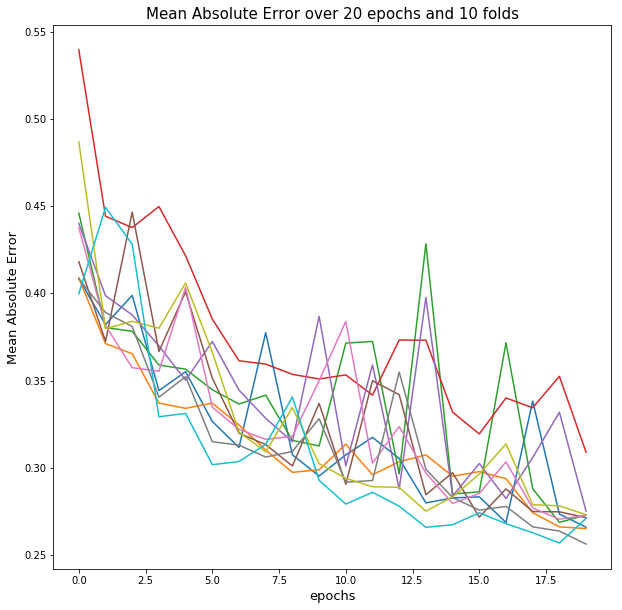

In [28]:
import matplotlib.pyplot as plt

for i in range(len(results)):
    plt.figure(1, figsize=(10,10))
    #plt.plot(results[i].history['mean_absolute_error'])
    plt.plot(results[i].history['val_mean_absolute_error'])
    plt.xlabel('epochs', fontsize =13)
    #plt.xticks(range(1,21))
    plt.ylabel('Mean Absolute Error', fontsize =13)
    plt.title('val Mean Absolute Error over 20 epochs and 10 folds', fontsize = 15)
    #plt.legend(['MAE'])
plt.show()

In [31]:
# minimum score of scores list
np.argmin(scores)

7

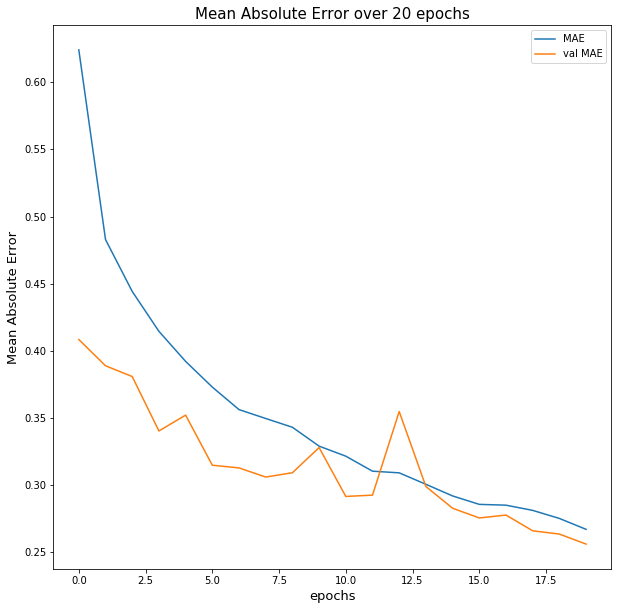

In [33]:
# plot of val MSE of 7th fold.
plt.figure(1, figsize=(10,10))
plt.plot(results[7].history['mean_absolute_error'])
plt.plot(results[7].history['val_mean_absolute_error'])
plt.xlabel('epochs', fontsize =13)
#plt.xticks(range(1,21))
plt.ylabel('Mean Absolute Error', fontsize =13)
plt.legend(['MAE','val MAE'])
plt.title('Mean Absolute Error over 20 epochs', fontsize = 15)
plt.show()


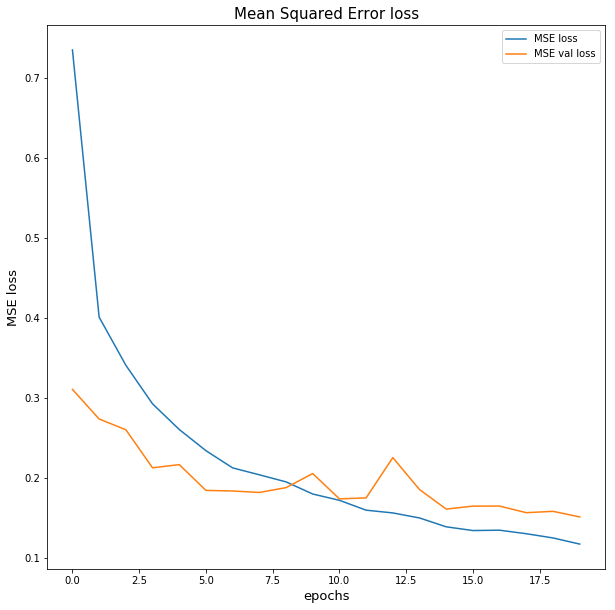

In [34]:
# plot of val los of 7th fold
plt.figure(1, figsize=(10,10))
plt.plot(results[7].history['loss'])
plt.plot(results[7].history['val_loss'])
plt.xlabel('epochs', fontsize =13)
plt.ylabel('MSE loss', fontsize =13)
plt.legend(['MSE loss','MSE val loss'])
plt.title('Mean Squared Error loss', fontsize = 15)
plt.show()


Examine if y_train and y_test distribution have different variance. (target value is logarithmically transformed)

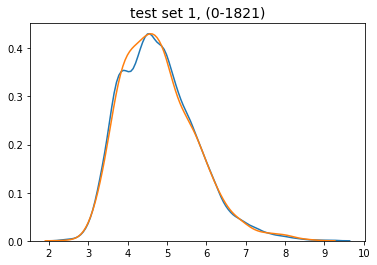

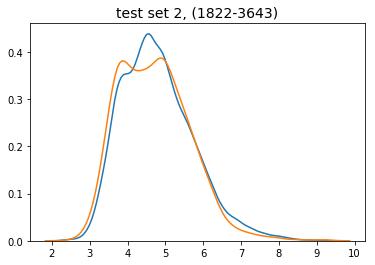

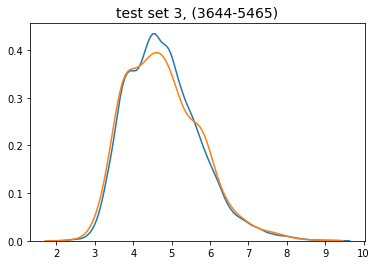

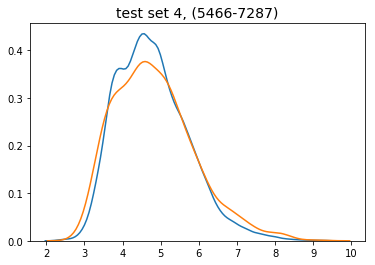

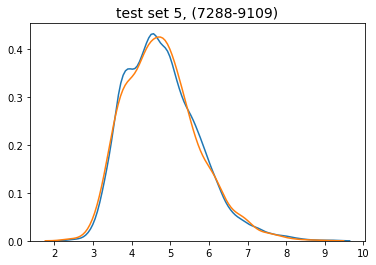

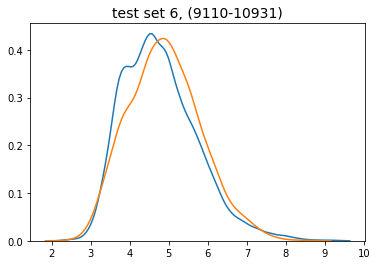

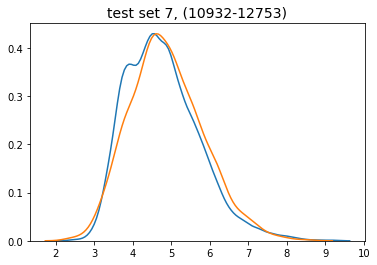

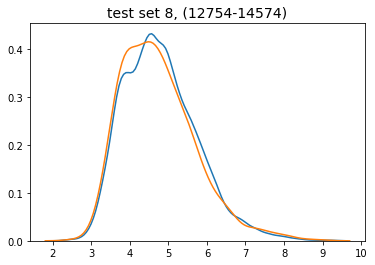

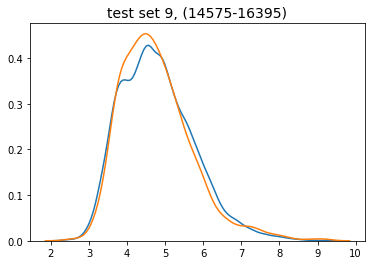

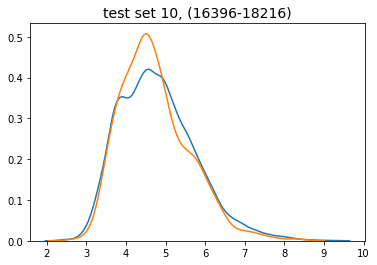

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

i=1
for train_index, test_index in kf.split(df.index):
    y_tr, y_tst = df.avg_cost_log.values[train_index], df.avg_cost_log.values[test_index]
    sns.distplot(df.avg_cost_log.values[train_index], hist = False)
    sns.distplot(df.avg_cost_log.values[test_index], hist = False)
    plt.title('test set {}, ({}-{})'.format(str(i), str(test_index[0]),str(test_index[-1])), fontsize = 14)
    i+=1
    plt.show()

### Summary & Conclusion

Starting with some cleaning and feature engineering to normalize the corpus and hence the vocabulary, then we did load some pre-trained word vectors (generated with Glove). Model is built with CNN layers for text data and fully connected Dense layers for categorical and continuous numeric data. 

Also using Kfold Cross Validation with k=10 for bias-variance trade-off, and plotting some curves and density distributions to visulalize results.

Few ways to improve performance are to add more data (maybe 10x times more data examples), so we could generate our 'airbnb' word embeddings. Otherwise we could use another dimension value of embed_size or another pre-trained model at all. The architecture is pretty shalow, and the dropout layers do not seem to help model achieve a better accuracy. Finally we could apply a totally different approach using sci-kit learn, but I believe using word embeddings is way better than using traditional NLP techniques (such as BOW model), eventhough we got a small dataset...